# TEAM 1 | Kris, Manju, Saritha, Srividya

In [1]:
# Imported packages
import pyodbc
import pandas as pd
import numpy as np
from numpy import median
from scipy import stats
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import warnings
# Filter FutureWarning related to category dtype
warnings.filterwarnings("ignore", category=FutureWarning)

*Function definitions: Database connection*

In [3]:
# Define the function to connect to the AdventureWorks 2022 database
def connect_to_sql_server():
    # Create a connection string
    db_server  = "localhost"
    db_database  = "AdventureWorks2022"
    
    connection_string = (
        f"DRIVER={{ODBC Driver 17 for SQL Server}};"
        f"SERVER={db_server};"
        f"DATABASE={db_database};"
        "Trusted_Connection=yes;"
    )
    
    # Connect to the database
    try:
        connection = pyodbc.connect(connection_string)
        return connection
    except Exception as e:
        print(f"Error connecting to database: {e}")
        return None

*Fetch Dataset*

In [5]:
# Define function to retrieve a dataset
def query_to_dataframe(connection, query):
    # Create a cursor
    cursor = connection.cursor()
    """
    Execute a query using the given cursor and return the results as a DataFrame.
    The cursor is closed within the function.
    
    Parameters:
    connection (pyodbc.connection): The database connection.
    query (str): The SQL query to execute.
    
    Returns:
    pd.DataFrame: The result of the query as a DataFrame.
    """
    
    try:
        cursor.execute(query)
        
        # Fetch the data and the column names
        data = cursor.fetchall()
              
        # Convert to DataFrame
        df = pd.DataFrame.from_records(data, columns=[desc[0] for desc in cursor.description])
        # Close the connection after usage
        connection.close()
        
        return df
    
    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()  # Return an empty DataFrame on error

## What is the regional sales in the best performing country?

### Best performing Country:

In [7]:
# Call the connect_to_sql_server function
connection = connect_to_sql_server()

#query to be used
query = '''
WITH DistinctStores AS (
    SELECT
        a.BusinessEntityID,
        a.CountryRegionName,
        d.AnnualRevenue
    FROM
        [AdventureWorks2022].[Sales].[vStoreWithAddresses] AS a
    JOIN
        [AdventureWorks2022].[Sales].[vStoreWithDemographics] AS d
        ON a.BusinessEntityID = d.BusinessEntityID
    GROUP BY
        a.BusinessEntityID, a.CountryRegionName, d.AnnualRevenue
)
SELECT
    CountryRegionName AS Country,
    SUM(AnnualRevenue) AS Revenue,
    COUNT(BusinessEntityID) AS Stores,
    ROUND(SUM(AnnualRevenue) / COUNT(BusinessEntityID), 0) AS Average
FROM
    DistinctStores
GROUP BY
    CountryRegionName
ORDER BY
    Stores DESC, Average DESC;
'''

# Call the function and get the DataFrame
countrytop = query_to_dataframe(connection, query)
countrytop.set_index('Country', inplace=True)
countrytop['Revenue'] = countrytop['Revenue'].astype(int)
countrytop['Average'] = countrytop['Average'].astype(int)
# Display the top performing country
countrytop

,Revenue,Stores,Average
Country,,,
United States,67360000,427,157752
Canada,17960000,114,157544
United Kingdom,6800000,40,170000
France,6650000,40,166250
Australia,6420000,40,160500
Germany,5900000,40,147500


### Regional sales in US:

In [11]:
# Call the connect_to_sql_server function
connection = connect_to_sql_server()

# SQL-query
query='''
WITH DistinctStores AS (
    SELECT
        a.BusinessEntityID,
        a.CountryRegionName,
        c.TerritoryID,
		SUM(DISTINCT d.AnnualRevenue) AS TotalRevenue
    FROM
        [AdventureWorks2022].[Sales].[vStoreWithAddresses] AS a
    JOIN
        [AdventureWorks2022].[Sales].[vStoreWithDemographics] AS d ON a.BusinessEntityID = d.BusinessEntityID
    JOIN
        [AdventureWorks2022].[Sales].[Customer] AS c ON a.BusinessEntityID = c.StoreID
	GROUP BY
        a.BusinessEntityID, a.CountryRegionName, c.TerritoryID, d.AnnualRevenue)
SELECT
    t.Name AS Territory,
	t.[CountryRegionCode] AS Country,
    COUNT(DISTINCT ds.BusinessEntityID) AS Stores,
	SUM(ds.TotalRevenue) AS Revenue,
    ROUND(SUM(ds.TotalRevenue) / NULLIF(COUNT(DISTINCT ds.BusinessEntityID), 0), 0) AS Average
FROM
    DistinctStores ds
JOIN
    [AdventureWorks2022].[Sales].[SalesTerritory] AS t ON ds.TerritoryID = t.TerritoryID
WHERE t.[CountryRegionCode] = 'US'
GROUP BY 
    t.Name, t.[CountryRegionCode]
ORDER BY
    Revenue DESC;
'''

# Call the function and get the DataFrame
USregions = query_to_dataframe(connection, query)

# Data type optimisation

USregions['Territory'] = USregions['Territory'].astype('category')
category_order = ['Southwest', 'Northwest', 'Southeast', 'Central', 'Northeast']
USregions['Territory'] = USregions['Territory'].astype(pd.CategoricalDtype(categories=category_order, ordered=True))
USregions['Stores'] = USregions['Stores'].astype(int)
USregions['Revenue'] = USregions['Revenue'].astype(int)
USregions['Average'] = USregions['Average'].astype(int)
USregions.set_index('Territory', inplace=True)
USregions

,Country,Stores,Revenue,Average
Territory,,,,
Southwest,US,131,21100000,161069
Northwest,US,92,15220000,165435
Southeast,US,85,12850000,151176
Central,US,63,9190000,145873
Northeast,US,56,9000000,160714


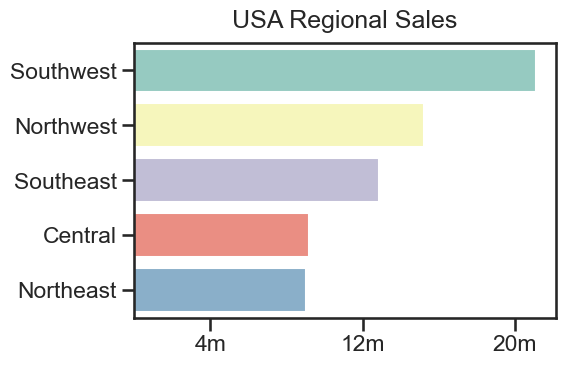

In [38]:
sns.set_theme(context='talk', style='ticks', palette='Set3', font='sans-serif', color_codes=True)

# Create the horizontal bar plot
plt.figure(figsize=(6, 4))
g = sns.barplot(x='Revenue', y=USregions.index, hue=USregions.index, data=USregions, orient='h', legend= False)
# Customize the plot
g.set_title('USA Regional Sales', y=1.025)
plt.xlabel('')
plt.ylabel('') 
xtick_positions = [4000000, 12000000, 20000000] 
xtick_labels = ['4m', '12m', '20m']
g.set_xticks(xtick_positions)
g.set_xticklabels(xtick_labels)
# Save the plot as a PNG file and display
plt.tight_layout()
plt.savefig('Downloads/sales_comparison_regional.png')
plt.show()

Southwest is the best preforming region in USA. 

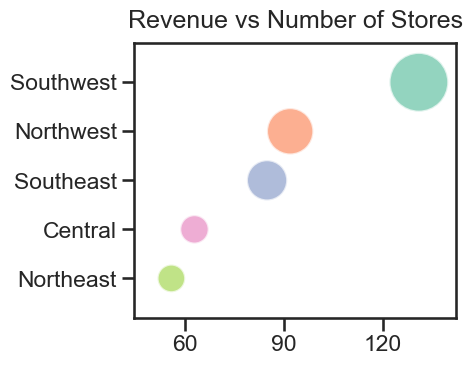

In [63]:
# Create a bubble plot
sns.set_theme(context='talk', style='ticks', palette='Set2', font='sans-serif', color_codes=True)
plt.figure(figsize=(5, 4))
g = sns.scatterplot(
    data=USregions,
    size='Revenue',
    y=USregions.index,
    hue=USregions.index,
    x='Stores',
    sizes=(400, 1800),  # You can adjust these values to scale the bubbles
    alpha=0.7,
    legend= False)
# Title and labels
plt.title('Revenue vs Number of Stores', y=1.025)
plt.xlabel('')
plt.ylabel('')
g.margins(x=0.15, y=0.2) 
xtick_positions = [60, 90, 120] 
xtick_labels = ['60', '90', '120']
g.set_xticks(xtick_positions)
g.set_xticklabels(xtick_labels)
# Save the plot as a PNG file and display
plt.tight_layout()
plt.savefig('Downloads/territoryrevenue.png')
plt.show()

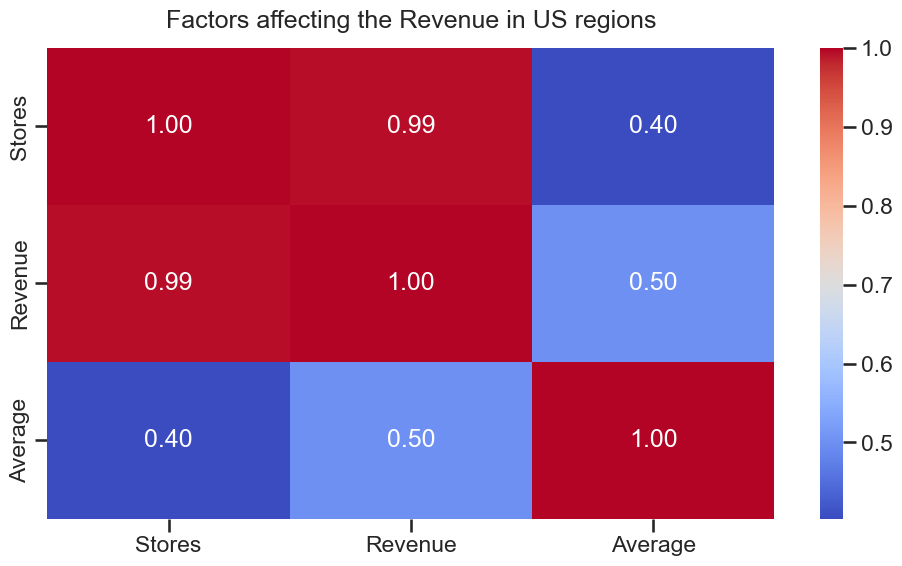

In [15]:
# Select numeric data from the DataFrame
numeric_data = USregions[['Stores', 'Revenue', 'Average']]

# Create the correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Factors affecting the Revenue in US regions', y=1.025)
# Save the plot as a PNG file and display
plt.tight_layout()
plt.savefig('Downloads/USregionsheatmap.png')
plt.show()

### ANOVA to test what effect Region has on Revenue

In [66]:
# Call the connect_to_sql_server function
connection = connect_to_sql_server()

# SQL-query
query='''
WITH DistinctStores AS (
    SELECT
        DISTINCT a.BusinessEntityID,
        a.CountryRegionName,
        c.TerritoryID,
        d.AnnualRevenue AS Revenue
    FROM
        [AdventureWorks2022].[Sales].[vStoreWithAddresses] AS a
    JOIN
        [AdventureWorks2022].[Sales].[vStoreWithDemographics] AS d ON a.BusinessEntityID = d.BusinessEntityID
    JOIN
        [AdventureWorks2022].[Sales].[Customer] AS c ON a.BusinessEntityID = c.StoreID
)
SELECT
    t.Name AS Territory,
    t.CountryRegionCode AS Country,
    ds.BusinessEntityID AS StoreID,
    ds.Revenue
FROM
    DistinctStores ds
JOIN
    [AdventureWorks2022].[Sales].[SalesTerritory] AS t ON ds.TerritoryID = t.TerritoryID
WHERE 
    t.[CountryRegionCode] = 'US'
ORDER BY
    ds.Revenue DESC;
'''

# Call the function and get the DataFrame
FullUSregions = query_to_dataframe(connection, query)

# Data type optimisation

FullUSregions['Territory'] = FullUSregions['Territory'].astype('category')
category_order = ['Southwest', 'Northwest', 'Southeast', 'Central', 'Northeast']
FullUSregions['Territory'] = FullUSregions['Territory'].astype(pd.CategoricalDtype(categories=category_order, ordered=True))
FullUSregions['StoreID'] = FullUSregions['StoreID'].astype(int)
FullUSregions['Revenue'] = FullUSregions['Revenue'].astype(int)

FullUSregions.set_index('Territory', inplace=True)
print(FullUSregions)

# Perform ANOVA using Pingouin
anova_region= pg.anova(dv='Revenue', between='Territory', data=FullUSregions.reset_index())
anova_region

          Country  StoreID  Revenue
Territory                          
Central        US      308   300000
Northwest      US      330   300000
Southwest      US      338   300000
Southeast      US      340   300000
Central        US      348   300000
...           ...      ...      ...
Southwest      US     1932    30000
Southwest      US     1934    30000
Northeast      US     1936    30000
Southwest      US     1990    30000
Southwest      US     1992    30000

[427 rows x 3 columns]


,Source,ddof1,ddof2,F,p-unc,np2
0,Territory,4,422,0.503965,0.732849,0.004754


Overall, the results suggest that the revenue differences among the various territories are not significant, and the territory itself does not explain a meaningful amount of variance in the revenue data. You might want to explore other factors or conduct further analyses to understand revenue performance better.

F: This is the F-statistic, which is the ratio of the variance between the groups to the variance within the groups. Here, the F-value is approximately 0.504. A higher F value typically indicates a greater difference between the group means relative to the variability within the groups.

Non-Significant Results: Since the p-value (0.733) is greater than the common significance level of 0.05, you fail to reject the null hypothesis. This means that there is no statistically significant difference in Revenue across the different Territories.

Small Effect Size: The partial eta-squared value of 0.0048 indicates a very small effect size, suggesting that the difference in Revenue between the Territories is negligible in practical terms.

## What is the relationship between Country and Revenue?

In [69]:
countrytop

,Revenue,Stores,Average
Country,,,
United States,67360000,427,157752
Canada,17960000,114,157544
United Kingdom,6800000,40,170000
France,6650000,40,166250
Australia,6420000,40,160500
Germany,5900000,40,147500


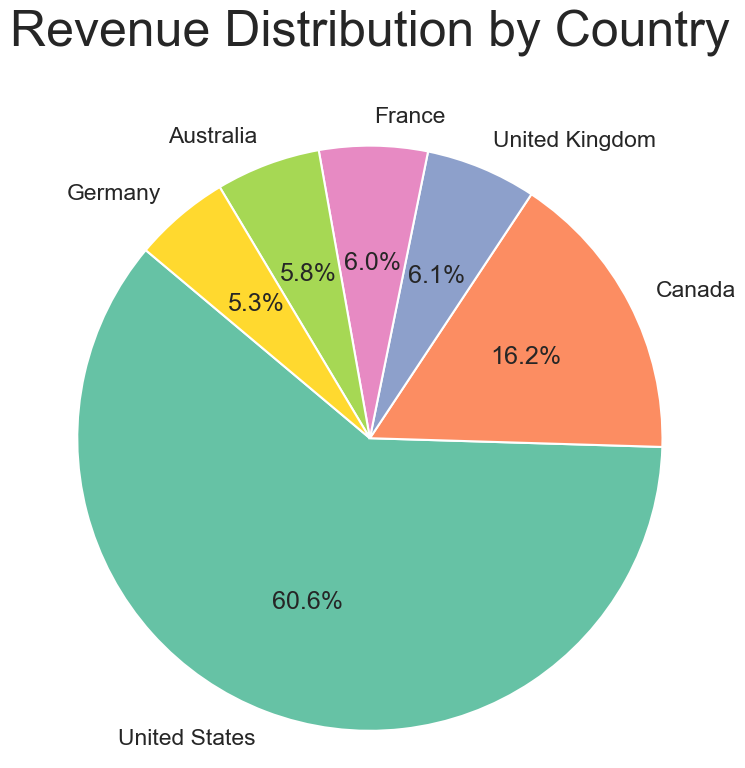

In [169]:
# Plot a pie chart to display the proportion of Revenue by Country
sns.set_theme(context='talk', style='ticks', palette='Set2', font='sans-serif', color_codes=True)
plt.figure(figsize=(8, 8))
plt.pie(countrytop['Revenue'], labels=countrytop.index, autopct='%1.1f%%', startangle=140)
plt.title('Revenue Distribution by Country', y=1.1, fontsize=36)
plt.axis('equal') 

# Show the pie chart
plt.tight_layout()
plt.savefig('Downloads/countryrevenuedist.png')
plt.show()

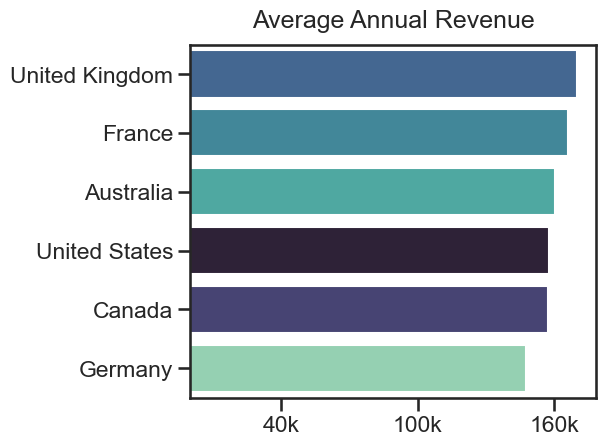

In [71]:
sns.set_theme(context='talk', style='ticks', palette='mako', font='sans-serif', color_codes=True)
avg_order = ['United Kingdom', 'France', 'Australia', 'United States', 'Canada', 'Germany']
g = sns.barplot(data=countrytop, y='Country', x='Average', hue='Country', orient='h', order=avg_order)
# Add labels and title
plt.title('Average Annual Revenue', y=1.025)
plt.xlabel('')
plt.ylabel('')
xtick_positions = [40000, 100000, 160000] 
xtick_labels = ['40k', '100k', '160k']
g.set_xticks(xtick_positions)
g.set_xticklabels(xtick_labels)
# Save the plot as a PNG file and display
plt.tight_layout()
plt.savefig('Downloads/averagerevenue.png')
plt.show()

In [73]:
# Call the connect_to_sql_server function
connection = connect_to_sql_server()

#query to be used
query = """
SELECT DISTINCT d.BusinessEntityID AS ID
    ,a.CountryRegionName AS Country
    ,d.AnnualSales AS Sales
    ,d.AnnualRevenue AS Revenue 
FROM [Sales].[vStoreWithDemographics] d
JOIN [Sales].[vStoreWithAddresses] a
ON d.BusinessEntityID = a.BusinessEntityID
ORDER BY AnnualRevenue desc;
"""

# Call the function and get the DataFrame
store_revenue = query_to_dataframe(connection, query)

# Display the DataFrame
country_order = ['United States', 'Canada', 'United Kingdom', 'France', 'Australia', 'Germany']
store_revenue['Country'] = pd.Categorical(store_revenue['Country'], categories=country_order, ordered=True)
store_revenue['Sales'] = store_revenue['Sales'].astype(int)
store_revenue['Revenue'] = store_revenue['Revenue'].astype(int)
store_revenue

,ID,Country,Sales,Revenue
0,308,United States,3000000,300000
1,330,United States,3000000,300000
2,338,United States,3000000,300000
3,340,United States,3000000,300000
4,346,Canada,3000000,300000
...,...,...,...,...
696,1934,United States,300000,30000
697,1936,United States,300000,30000
698,1988,Canada,300000,30000
699,1990,United States,300000,30000


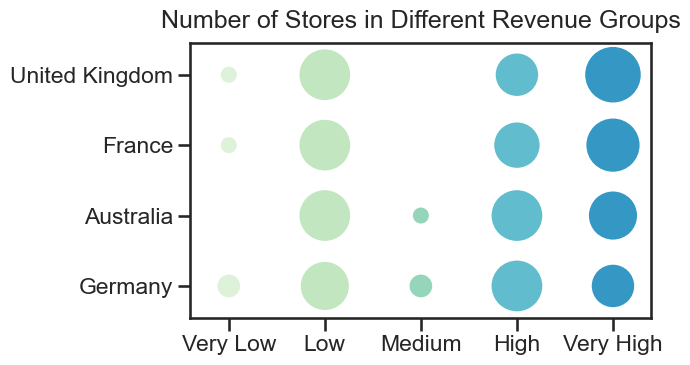

In [75]:
sns.set_theme(context='talk', style='ticks', palette='GnBu', font='sans-serif', color_codes=True)

# Create Revenue groups based on the new thresholds: 300000, 150000, 100000, 80000, 30000
store_revenue['Group'] = pd.cut(store_revenue['Revenue'], 
                                       bins=[0, 30000, 80000, 100000, 150000, 300000], 
                                       labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# Filter out United States and Canada
filtered_store_revenue = store_revenue[store_revenue['Country'].isin(['United Kingdom', 'France', 'Australia', 'Germany'])]

# Aggregate the data to count observations in each revenue group for each country and remove
bubble_data = filtered_store_revenue.groupby(['Country', 'Group']).size().reset_index(name='Count')
bubble_data = bubble_data[bubble_data['Count'] > 0]

# Create Bubble Chart using Seaborn scatterplot
y_order = ['United Kingdom', 'France', 'Australia', 'Germany']
plt.figure(figsize=(7, 4))
g = sns.scatterplot(data=bubble_data, y='Country', x='Group', size='Count', hue='Group', legend=False, sizes=(0, 1600))

# Labels and title
plt.title('Number of Stores in Different Revenue Groups', y=1.025)
plt.xlabel('')
plt.ylabel('')
g.margins(x=0.1, y=0.15) 
# Save the plot as a PNG file and display
plt.tight_layout()
plt.savefig('Downloads/countryrevenuegroups.png')
plt.show()

The Average revenue is related to how effectively different countries have been in converting High performing stores to Very High performing stores.

In [80]:
store_revenue['Revenue'] = pd.to_numeric(store_revenue['Revenue'], errors='coerce')

# Perform ANOVA using Pingouin
anova_country = pg.anova(dv='Revenue', between='Country', data=store_revenue)

# Display the ANOVA result
anova_country

,Source,ddof1,ddof2,F,p-unc,np2
0,Country,5,695,0.269515,0.929791,0.001935


In summary, the ANOVA results suggest that there is no significant difference in revenue among the different countries in your dataset.

F-statistic: The F-statistic is a ratio of the variance between the group means (i.e., variance between countries) to the variance within groups (i.e., variance within each country). In this case, the F-value is 0.27, which is quite low. This indicates that the differences between the countries' revenues are not large compared to the variability within countries.

Non-significant result: With a p-value of 0.93, we fail to reject the null hypothesis. This means there is no statistically significant evidence to conclude that revenue differs across the six countries.

## What is the relationship between store trading duration and revenue?

In [82]:
# Call the connect_to_sql_server function
connection = connect_to_sql_server()

#query to be used
query="SELECT AnnualRevenue, YearOpened, SquareFeet, NumberEmployees FROM [AdventureWorks2022].[Sales].[vStoreWithDemographics]"

# Call the function and get the DataFrame
trading = query_to_dataframe(connection, query)

# Calculating store age
trading["AnnualRevenue"] = trading["AnnualRevenue"].astype(int)
trading['store_duration']= 2014 - trading['YearOpened'] 
trading

,AnnualRevenue,YearOpened,SquareFeet,NumberEmployees,store_duration
0,300000,1979,72000,66,35
1,150000,1974,39000,40,40
2,150000,1980,41000,43,34
3,150000,1986,40000,46,28
4,30000,1973,6000,2,41
...,...,...,...,...,...
696,30000,1982,7000,8,32
697,30000,1976,7000,5,38
698,30000,1970,6000,2,44
699,80000,1997,19000,17,17


In [84]:
# Create bins for store duration
bins = [10, 15, 20, 25, 30, 35, 40, 45]
labels = ['11-15', '16-20', '21-25', '26-30', '31-35', '36-40', '41-45']
trading['store_duration_group'] = pd.cut(trading['store_duration'], bins=bins, labels=labels, right=False)

# Perform ANOVA using Pingouin
anova_storeage = pg.anova(dv='AnnualRevenue', between='store_duration_group', data=trading)
anova_storeage

,Source,ddof1,ddof2,F,p-unc,np2
0,store_duration_group,6,694,8.39407,8.327942e-09,0.067661


Overall, the results of the ANOVA test suggest that there is a significant relationship between store duration groups and annual revenue. This means that the amount of annual revenue varies significantly across different store duration groups.

F-Statistic: 
F = 8.39407: The F-statistic is a ratio of the variance between the group means to the variance within the groups. A higher F-statistic indicates that the group means are more different from each other relative to the variability within the groups. In this case, an F-statistic of 8.39407 suggests that there is a significant difference in annual revenue between different store duration groups

P-value: 
p-unc = 8.327942e-09: The p-value indicates the probability of observing the data if the null hypothesis (no relationship between store duration groups and annual revenue) is true. A p-value of 8.327942e-09 is extremely low, suggesting that the observed differences in annual revenue between store duration groups are statistically significant. In other words, there is a very low probability that the observed differences could have occurred by chance.
Partial Eta Squared: 
np2 = 0.067661: Partial Eta Squared is a measure of effect size, indicating the proportion of the total variance that is attributable to the factor (store duration group). A value of 0.067661 suggests that approximately 6.77% of the variance in annual revenue can be explained by the store duration group..


In [86]:
# Correlation between Annual Revenue and Store age
correlation_result = pg.corr(trading['AnnualRevenue'], trading['store_duration'])
correlation_result

,n,r,CI95%,p-val,BF10,power
pearson,701,-0.133645,"[-0.21, -0.06]",0.000388,25.282,0.944584


Overall, the results suggest that there is a statistically significant, albeit weak, negative correlation between the annual revenue and the store age in this dataset.

(Pearson Correlation Coefficient): 
r = -0.133645: This is the Pearson correlation coefficient, which measures the strength and direction of the linear relationship between AnnualRevenue and store_duration. A value of -0.133645 indicates a weak negative correlation, meaning that as the store age increases, the annual revenue tends to decrease slightly

p-val = 0.000388: The p-value indicates the probability of observing the data if the null hypothesis (no correlation) is true. A p-value of 0.000388 is very low, suggesting that the observed correlation is statistically significant. In other words, there is a very low probability that the observed correlation could have occurred by chance.

BF10 (Bayes Factor): 
BF10 = 25.282: The Bayes Factor quantifies the evidence for the alternative hypothesis (there is a correlation) relative to the null hypothesis (no correlation). A BF10 value of 25.282 indicates strong evidence against the null hypothesis. Values greater than 10 are generally considered strong evidence.

power = 0.944584: Statistical power is the probability of correctly rejecting the null hypothesis when it is false. A power of 0.944584 is quite high, indicating that the test has a high probability of detecting a true correlation if it exists..

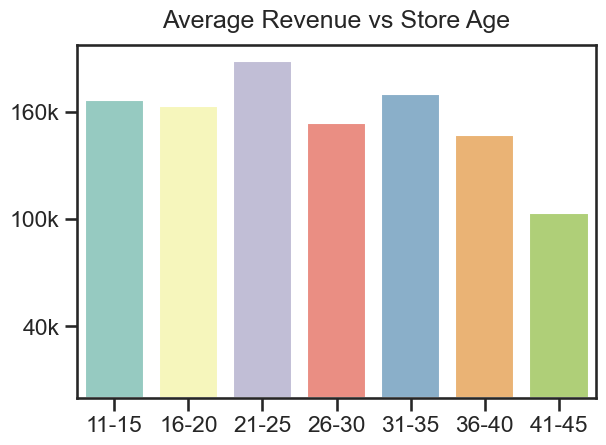

In [173]:
# Define age ranges (bins)
bins = [10, 15, 20, 25, 30, 35, 40, 45]
labels = ['11-15', '16-20', '21-25', '26-30', '31-35', '36-40', '41-45']
trading['age_range'] = pd.cut(trading['store_duration'], bins=bins, labels=labels)
# Aggregate data to find average revenue for each age range
age_revenue = trading.groupby('age_range').agg({'AnnualRevenue': 'mean'}).reset_index()

sns.set_theme(context='talk', style='ticks', palette='Set3', font='sans-serif', color_codes=True)
g = sns.barplot(data=age_revenue, x='age_range', y='AnnualRevenue', hue='age_range')

g.yaxis.set_major_locator(MaxNLocator(nbins=5))
ytick_positions = [40000, 100000, 160000] 
ytick_labels = ['40k', '100k', '160k']
g.set_yticks(ytick_positions)
g.set_yticklabels(ytick_labels)
plt.xlabel('')
plt.ylabel('')
plt.title('Average Revenue vs Store Age', y=1.025)
# Save the plot as a PNG file and display
plt.tight_layout()
plt.savefig('Downloads/avgstorerev')
plt.show()

Chart shows revenue around 160k on average for stores upto age 40 , but oldest stores have considerably lower averages.

## What is the relationship between the size of the stores, number of employees and revenue?

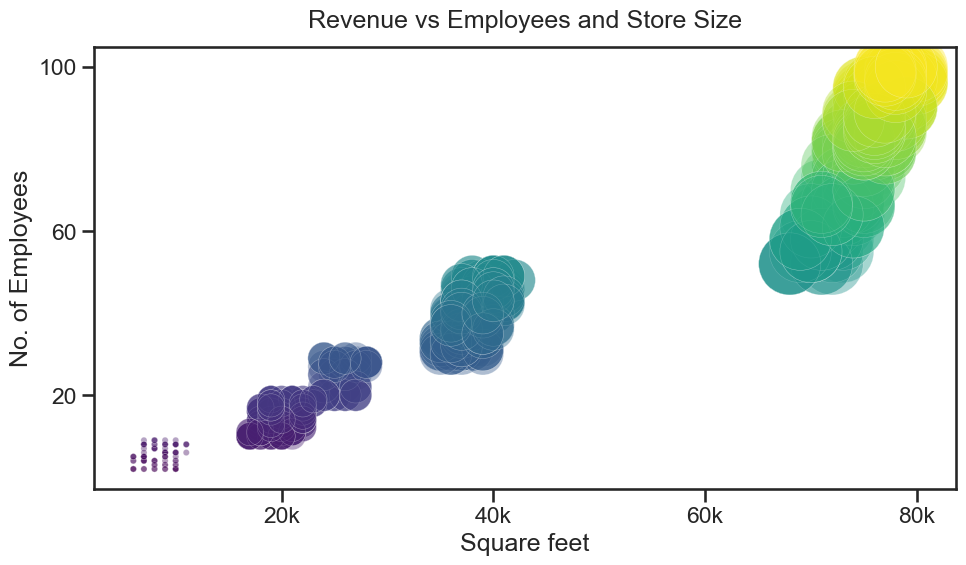

In [92]:
# Create a bubble plot
sns.set_theme(context='talk', style='ticks', font='sans-serif', palette='viridis', color_codes=True)
trading["AnnualRevenue"] = trading["AnnualRevenue"].astype(float)

# Bubble chart of store_size, num_employees, and revenue
plt.figure(figsize=(10, 6))
sns.scatterplot(x='SquareFeet', y='NumberEmployees', size='AnnualRevenue', data=trading, hue='NumberEmployees', palette='viridis', sizes=(20, 2000), legend=False, alpha=0.4)

# Customize the plot
ax = plt.gca()
ytick_positions = [20, 60, 100] 
ytick_labels = ['20', '60', '100']
ax.set_yticks(ytick_positions)
ax.set_yticklabels(ytick_labels)
xtick_positions = [20000, 40000, 60000, 80000] 
xtick_labels = ['20k', '40k', '60k', '80k']
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels)

plt.xlabel('Square feet')
plt.ylabel('No. of Employees')
plt.title('Revenue vs Employees and Store Size', y=1.025)
# Save the plot as a PNG file and display
plt.tight_layout()
plt.savefig('Downloads/revsizevemp')
plt.show()

In [94]:
# Calculate the correlation matrix
correlation_matrix = pg.pairwise_corr(trading[["AnnualRevenue", "SquareFeet", "NumberEmployees"]])
correlation_matrix

,X,Y,method,alternative,n,r,CI95%,p-unc,BF10,power
0,AnnualRevenue,SquareFeet,pearson,two-sided,701,0.996531,"[1.0, 1.0]",0.0,inf,1.0
1,AnnualRevenue,NumberEmployees,pearson,two-sided,701,0.958107,"[0.95, 0.96]",0.0,inf,1.0
2,SquareFeet,NumberEmployees,pearson,two-sided,701,0.971782,"[0.97, 0.98]",0.0,inf,1.0


Overall, the results suggest that there are very strong and statistically significant positive correlations between Annual Revenue, Square Feet, and Number of Employees in this dataset.

Pearson Correlation Coefficient:
r = 0.996531 for AnnualRevenue and SquareFeet: This indicates a very strong positive correlation between Annual Revenue and Square Feet.
r = 0.958107 for AnnualRevenue and NumberEmployees: This indicates a strong positive correlation between Annual Revenue and Number of Employees.
r = 0.971782 for SquareFeet and NumberEmployees: This indicates a very strong positive correlation between Square Feet and Number of Employe

s.(P-vaue): 
p-unc = 0.0 for all pairs: The p-value indicates the probability of observing the data if the null hypothesis (no correlation) is true. A p-value of 0.0 suggests that the observed correlations are statistically significantBayes Factor: 
BF10 = inf for all pairs: The Bayes Factor quantifies the evidence for the alternative hypothesis (there is a correlation) relative to the null hypothesis (no correlation). A BF10 value of inf indicates extremely strong evidence against the null hypothesis. Statistical Power: 
power = 1.0 for all pairs: Statistical power is the probability of correctly rejecting the null hypothesis when it is false. A power of 1.0 indicates that the test has a very high probability of detecting a true correlation if it exists.



.The correlation matrix indicates that all three variables—Annual Revenue, Square Feet, and Number of Employees—are very strongly positively correlated with each other. SpecificaThe confidence intervals suggest that the correlation estimates are very precise. lly:

Larger store sizes (Square Feet) are associated with higher Annual Revenue and more Employees. Stores with more Employees tend to have higher Annual Revenue. The very high correlation values (close to 1) suggest a nearly linear relationship between these variables. These insights can help in understanding the dynamics between store size, staffing, and revenue generation

This is further emphasized by the bubble chart , Larger store sizes (Square Feet) are associated with higher Annual Revenue and more Employee and vice-versa.

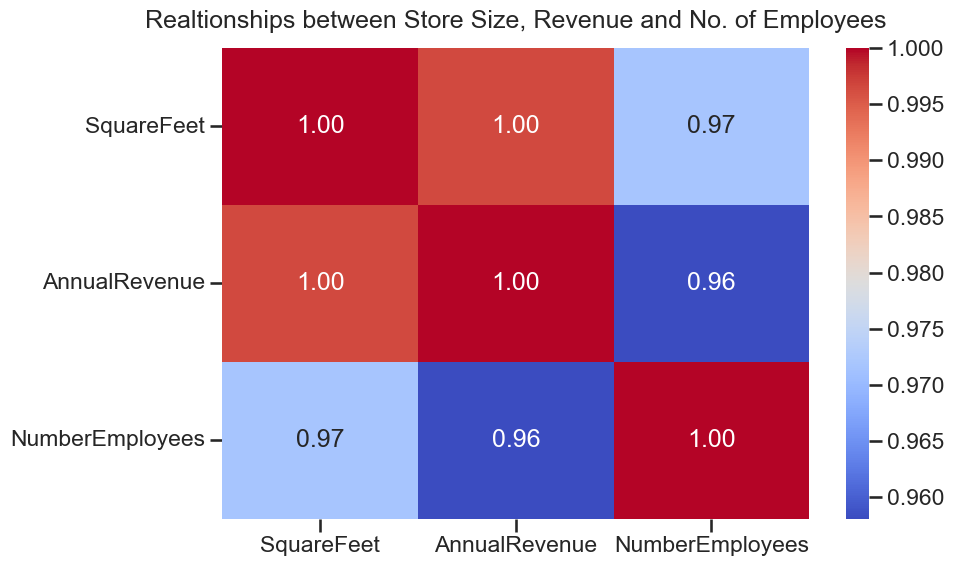

In [97]:
# Select numeric data from the DataFrame
numeric_trade = trading[['SquareFeet', 'AnnualRevenue', 'NumberEmployees']]
# Create the correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_trade.corr(), annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Realtionships between Store Size, Revenue and No. of Employees', y=1.025)
# Save the plot as a PNG file and display
plt.tight_layout()
plt.savefig('Downloads/StoreRelationships.png')
plt.show()

## What is the relationship between sick leave and Job Title?

In [99]:
# Call the connect_to_sql_server function
connection = connect_to_sql_server()

#query to be used
query = "SELECT JobTitle, SickLeaveHours FROM HumanResources.Employee"

# Call the function and get the DataFrame
sickleave = query_to_dataframe(connection, query)

# Display the DataFrame
sickleave

,JobTitle,SickLeaveHours
0,Chief Executive Officer,69
1,Vice President of Engineering,20
2,Engineering Manager,21
3,Senior Tool Designer,80
4,Design Engineer,22
...,...,...
285,Sales Representative,38
286,European Sales Manager,30
287,Sales Representative,37
288,Sales Representative,38


In [101]:
# Create a categories list to group job titles 
sl_categories = ['Manager', 'Engineer', 'Supervisor', 'Specialist', 'Technician', 'Assistant', 'Accountant',
              'Buyer', 'Sales', 'Designer', 'Officer', 'Vice President', 'Master', 'Recruiter', 'Janitor',
             'Administrator', 'Stocker', 'Clerk']

# Create a new column called 'Category' with default value 'Other'
sickleave['JobCategory'] = 'Other'

# Loop through categories list and update 'Category' column
for category in sl_categories:
    sickleave.loc[sickleave['JobTitle'].str.contains(category), 'JobCategory'] = category

In [103]:
# Create a dictionary for merging groups
sl_replace_dict = {
    'Buyer': 'Sales/Buyers',
    'Sales': 'Sales/Buyers',
    'Officer': 'Executives',
    'Vice President': 'Executives',
    'Manager': 'Managers',
    'Engineer': 'Managers',
    'Designer': 'Managers',
    'Master': 'Specialists',
    'Specialist': 'Specialists',
    'Administrator': 'Specialists',
    'Accountant': 'Specialists',
    'Recruiter': 'Assistants',
    'Assistant': 'Assistants',
    'Janitor': 'Support',
    'Stocker': 'Support',
    'Clerk': 'Support'}

# Replace old categories with new categories
sickleave['JobCategory'] = sickleave['JobCategory'].replace(sl_replace_dict)

In [105]:
# Function to replace outliers with the median value
def replace_outliers_with_median(df, job_category):
    Q1 = df[df['JobCategory'] == job_category]['SickLeaveHours'].quantile(0.25)
    Q3 = df[df['JobCategory'] == job_category]['SickLeaveHours'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    median_value = df[df['JobCategory'] == job_category]['SickLeaveHours'].median()
    
    df.loc[(df['JobCategory'] == job_category) & 
           ((df['SickLeaveHours'] < lower_bound) | (df['SickLeaveHours'] > upper_bound)), 
           'SickLeaveHours'] = median_value

# Replace outliers for 'Assistant'
replace_outliers_with_median(sickleave, 'Assistants')

# Replace outliers for 'Supervisor'
replace_outliers_with_median(sickleave, 'Supervisor')

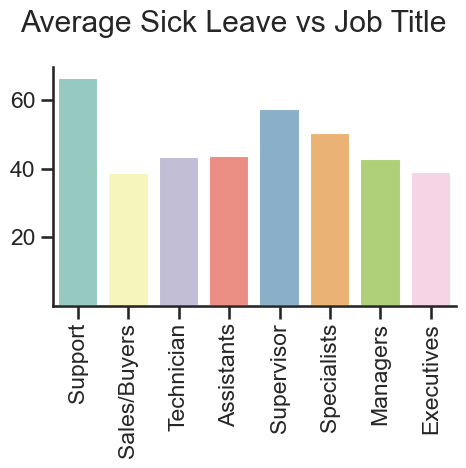

In [107]:
sns.set_theme(context='talk', style='ticks', palette='Set3', font='sans-serif', color_codes=True)
# Create a box plot for each job title category
sickleave_order =['Support', 'Sales/Buyers', 'Technician', 'Assistants', 'Supervisor', 'Specialists', 'Managers', 'Executives']
g = sns.catplot(data=sickleave, x='JobCategory', y='SickLeaveHours', hue='JobCategory', kind='bar', order=sickleave_order, hue_order=sickleave_order, ci=None)
# Set y-ticks and y-tick labels on the Axes object
g.fig.suptitle("Average Sick Leave vs Job Title", y=0.95)
g.set(xlabel="", ylabel='')
ax = g.ax
ytick_positions = [20, 40, 60]
ytick_labels = ['20', '40', '60']
ax.set_yticks(ytick_positions)
ax.set_yticklabels(ytick_labels)
plt.xticks(rotation=90)
# Save the plot as a PNG file and display
plt.tight_layout()
plt.savefig('Downloads/SickLeaveByTitle.png')
plt.show()

In [109]:
# Create a list of arrays representing sick leave per job category
sickleave_array = [group['SickLeaveHours'].values for name, group in sickleave.groupby('JobCategory')]

# Preform ANOVA - H0 : There's no relationship between between job titles and sick leave hours 
anova_jobtitles = pg.anova(dv='SickLeaveHours', between='JobCategory', data=sickleave)
anova_jobtitles

,Source,ddof1,ddof2,F,p-unc,np2
0,JobCategory,7,282,8.140242,4.978964e-09,0.168097


Overall, the results of the ANOVA test suggest that there is a significant relationship between job titles and sick leave hours. This means that the amount of sick leave taken varies significantly across different job categories.

F-Statistic: 
F = 8.140242: The F-statistic is a ratio of the variance between the group means to the variance within the groups. A higher F-statistic indicates that the group means are more different from each other relative to the variability within the groups. In this case, an F-statistic of 8.140242 suggests that there is a significant difference in sick leave hours between different job categories

P-value: 
p-unc = 4.978964e-09: The p-value indicates the probability of observing the data if the null hypothesis (no relationship between job titles and sick leave hours) is true. A p-value of 4.978964e-09 is extremely low, suggesting that the observed differences in sick leave hours between job categories are statistically significant. In other words, there is a very low probability that the observed differences could have occurred by chance

Partial Eta Squared: 
np2 = 0.168097: Partial Eta Squared is a measure of effect size, indicating the proportion of the total variance that is attributable to the factor (job category). A value of 0.168097 suggests that approximately 16.81% of the variance in sick leave hours can be explained by the job category...

In [111]:
# Create a new DataFrame for Technicians
technician = sickleave.loc[sickleave['JobCategory'] == 'Technician']
tech_replace_dict = {'Quality':'QA'}

warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

# Replace old categories with new categories
technician.loc[:, 'ShortTitle'] = technician['JobTitle'].str.extract(r'(\d+|Quality)')
technician.loc[:, 'ShortTitle'] = technician['ShortTitle'].replace(tech_replace_dict)

# Create a new column with short version of JobTitle
technician['ShortTitle'] = technician['JobTitle'].str.extract(r'(\d+|Quality)')

# Create a dictionary to unify midcareer technician roles
tech_replace_dict = {'Quality':'QA'}

# Replace old categories with new categories
technician['ShortTitle'] = technician['ShortTitle'].replace(tech_replace_dict)

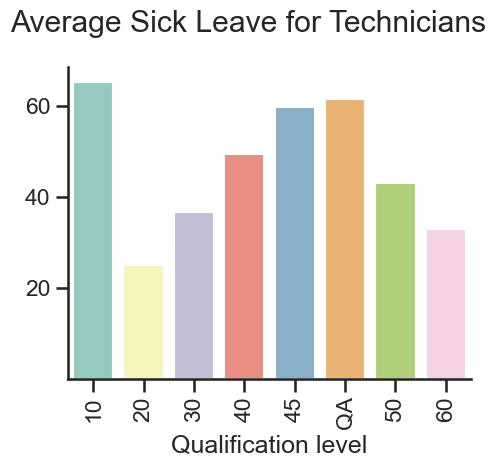

In [176]:
sns.set_theme(context='talk', style='ticks', palette='Set3', font='sans-serif', color_codes=True)
# Create a bar plot for each category
technician_order = ['10', '20', '30', '40', '45', 'QA', '50', '60']
g = sns.catplot(data=technician, x='ShortTitle', y='SickLeaveHours', hue='ShortTitle', kind='bar', order=technician_order, hue_order=technician_order, ci=None)
g.fig.suptitle("Average Sick Leave for Technicians", y=0.95)
g.set(xlabel="Qualification level", ylabel='')
ax = g.ax
# Set y-ticks and y-tick labels on the Axes object
ytick_positions = [20, 40, 60]
ytick_labels = ['20', '40', '60']
ax.set_yticks(ytick_positions)
ax.set_yticklabels(ytick_labels)
plt.xticks(rotation=90)
# Save the plot as a PNG file and display
plt.tight_layout()
plt.savefig('Downloads/SickLeaveTechnicians.png')
plt.show()

In [115]:
# Create a list of arrays representing sick leave per job category
sickleave_tech = [group['SickLeaveHours'].values for name, group in technician.groupby('JobTitle')]

# Preform ANOVA - H0 : There's no relationship between between job titles and sick leave hours 
anova_technician = pg.anova(dv='SickLeaveHours', between='ShortTitle', data=technician)
anova_technician

,Source,ddof1,ddof2,F,p-unc,np2
0,ShortTitle,7,153,40.861806,5.398665e-32,0.651507


Overall, the results of the ANOVA test suggest that there is a significant relationship between job titles and sick leave hours among technicians. This means that the amount of sick leave taken varies significantly across different job titles within the technician group.

F-Statistic: 
F = 40.861806: The F-statistic is a ratio of the variance between the group means to the variance within the groups. A higher F-statistic indicates that the group means are more different from each other relative to the variability within the groups. In this case, an F-statistic of 40.861806 suggests that there is a significant difference in sick leave hours between different job title for technicianss

P-value: 
p-unc = 5.398665e-32: The p-value indicates the probability of observing the data if the null hypothesis (no relationship between job titles and sick leave hours) is true. A p-value of 5.398665e-32 is extremely low, suggesting that the observed differences in sick leave hours between job titles are statistically significant. In other words, there is a very low probability that the observed differences could have occurred by chance

np2 (Partial Eta Squared): This represents the effect size or the proportion of the total variance in SickLeaveHours explained by ShortTitle. A value of 0.651507 indicates a very large effect size, meaning job titles explain about 65% of the variance in sick leave hours...

## What is the relationship between annual leave taken and bonus?

In [120]:
# Call the connect_to_sql_server function
connection = connect_to_sql_server()

#query to be used
query = '''
    SELECT e.VacationHours, s.Bonus 
    FROM HumanResources.Employee AS e 
    INNER JOIN Sales.SalesPerson AS s 
    ON e.BusinessEntityID = s.BusinessEntityID;
    '''

# Call the function and get the DataFrame
bonus = query_to_dataframe(connection, query)

# Change the datatype of Bonus-column to integer
bonus['Bonus'] = bonus['Bonus'].astype(int)

# Group VacationHours into three bins
bonus_bins = [13, 24, 34, 44]
bonus_labels = ['< 25', '25-34', '> 34']
bonus['VacationCategory'] = pd.cut(bonus['VacationHours'], bins=bonus_bins, labels=bonus_labels)

# Create a list of arrays representing sick leave per job category
bonus_array = [group['VacationHours'].values for name, group in bonus.groupby('VacationCategory')]

In [122]:
# Define a function to detect outliers using IQR
def replace_outliers_with_median(group, column_name):
    # Calculate the IQR
    Q1 = group[column_name].quantile(0.25)
    Q3 = group[column_name].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Calculate the median for the group
    median_value = group[column_name].median()
    
    # Replace outliers with the median
    group[column_name] = np.where((group[column_name] < lower_bound) | (group[column_name] > upper_bound),
                                  median_value, group[column_name])
    return group

# Apply the function to the group where VacationCategory is '> 34'
bonus_group_above_34 = bonus[bonus['VacationCategory'] == '> 34']
bonus_group_above_34 = replace_outliers_with_median(bonus_group_above_34, 'Bonus')

# Update the original DataFrame
bonus.update(bonus_group_above_34)

# Display the updated DataFrame
bonus.describe()

,VacationHours,Bonus
count,17.000000,17.000000
mean,28.764706,3096.176471
std,7.361466,2172.562952
min,14.000000,0.000000
25%,23.000000,985.000000
50%,29.000000,3550.000000
75%,35.000000,5000.000000
max,39.000000,6700.000000


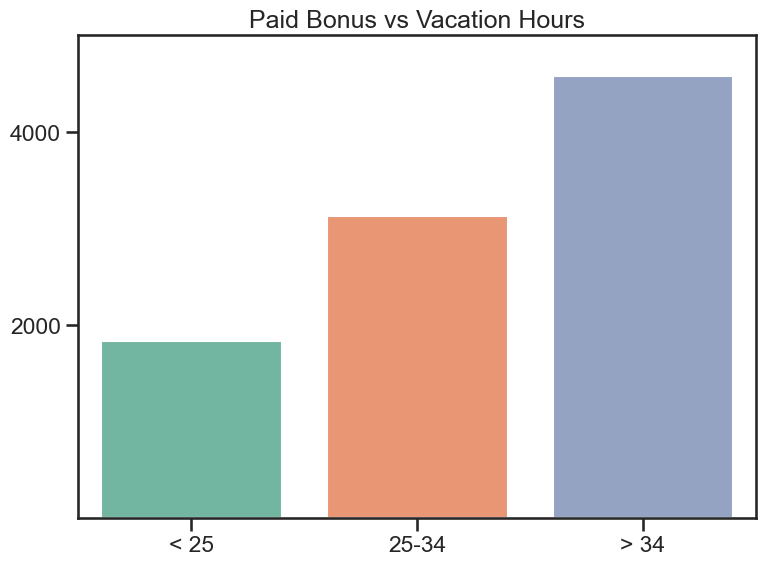

In [124]:
sns.set_theme(context='talk', style='ticks', palette='Set2', font='sans-serif', color_codes=True)
# Define the order of categories
category_order = ['< 25', '25-34', '> 34']

# Create a bar plot of Bonus by VacationCategory
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust the size as needed
sns.barplot(ax=ax, data=bonus, x='VacationCategory', y='Bonus', hue='VacationCategory', order=category_order, ci=None, legend=False)

# Customize the plot appearance
ax.set_xlabel('')
ax.set_ylabel('')
ax.yaxis.tick_left()
ax.set_ylim([0, 5000])
ax.set_yticks(range(2000, 5001, 2000))

# Set the title and labels
plt.title("Paid Bonus vs Vacation Hours")
plt.xlabel('')

# Save the figure if needed
plt.tight_layout()
plt.savefig('Downloads/BonusVacationHours.png')

# Display the plot
plt.show()

In [128]:
# Spearman correlation test using pingouin
bonus_corr = pg.corr(bonus['Bonus'], bonus['VacationHours'], method='spearman')
bonus_corr

,n,r,CI95%,p-val,power
spearman,17,0.557199,"[0.1, 0.82]",0.020145,0.673827


In summary, the results indicate a statistically significant moderate positive correlation between Bonus and VacationHours.

Correlation Coefficient: r: This is the Spearman correlation coefficient, which measures the strength and direction of the monotonic relationship between two variables. Here, the value is 0.557199, indicating a moderate positive correlation between Bonus and VacationHours. As Bonus increases, VacationHours tends to increase as well.

p-value: The p-value associated with the correlation coefficient indicates the probability of observing the data if the null hypothesis (no correlation) is true. Here, the p-value is 0.020145, which is less than the common significance level of 0.05. This suggests that the correlation is statistically significant. We can reject the null hypothesis and conclude that there is a significant correlation between Bonus and VacationHours.

power: This represents the statistical power of the test, which is the probability of correctly rejecting the null hypothesis when it is false. Here, the power is 0.673827, indicating a moderate probability of detecting a true correlation if it exists.